In [99]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams["figure.figsize"]= (20,10)
pd.set_option('float_format', '{:f}'.format)
from tqdm import tqdm
tqdm.pandas()


In [66]:
df = pd.read_csv("Assessment exercise dataset - orders.csv")

In [67]:
df.head()

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount
0,7322173742136,94223136441,2022-01-18 15:41:28 UTC,Αίγιο,Breakfast,True,3.600000
1,7210978616924,204794985423,2022-01-02 17:50:50 UTC,Αγρίνιο,Breakfast,True,1.900000
2,7221232906132,12703920390,2022-01-04 08:37:12 UTC,Αγρίνιο,Breakfast,True,1.700000
3,7399605199800,673310109528,2022-01-31 11:33:05 UTC,Λιβαδειά,Breakfast,True,3.000000
4,7264221279744,673310109528,2022-01-10 11:18:28 UTC,Λιβαδειά,Breakfast,True,3.000000


In [68]:
print(df.shape)
print(df.describe())

(534270, 7)
                  order_id             user_id        amount
count        534270.000000       534270.000000 534270.000000
mean  7308039168817.732422 305801389311.825989      8.522366
std     59032774955.155800 207703286609.478973      6.095029
min   7202715412520.000000     44118921.000000      0.400000
25%   7256096415925.000000 133336177170.000000      4.600000
50%   7310697147038.000000 255130792854.000000      6.700000
75%   7363636720530.000000 517421918391.000000     10.800000
max   7404766224920.000000 685567924230.000000    204.800000


In [69]:
df['order_id'] = df['order_id'].astype("str")
df['user_id'] = df['user_id'].astype("str")
df.dtypes

order_id            object
user_id             object
order_timestamp     object
city                object
cuisine             object
paid_cash             bool
amount             float64
dtype: object

In [70]:
df_Breakfast_or_not  = pd.DataFrame(df.cuisine.value_counts()/df.shape[0]).reset_index().rename(columns={"index":'cuisine', "cuisine":'percentages'})
df_Breakfast_or_not

,cuisine,percentages
0,Breakfast,0.389247
1,Meat,0.343128
2,Italian,0.169908
3,Street food,0.097717


## All meal customers

In [126]:
df_groupedby_user = df.groupby('user_id').agg({'order_id': "count",
                             'amount': 'sum'}).reset_index(drop=False)
                             
df_groupedby_user['amount_per_order'] = df_groupedby_user.amount/df_groupedby_user.order_id

df_groupedby_user.sort_values(['order_id', 'amount'], 
                                ascending= [False, False],
                                #inplace=True
                                )
df_groupedby_user.head()

,user_id,order_id,amount,amount_per_order
0,100001680044,8,66.300000,8.287500
1,100005820236,1,8.700000,8.700000
2,100008019713,2,46.100000,23.050000
3,100009701666,3,23.000000,7.666667
4,100015523811,2,14.300000,7.150000


## Clustering Analysis

In [76]:
df_groupedby_user_noID = df_groupedby_user.drop('user_id', axis=1) # Drop user_id for clustering analysis

In [77]:
'''
Compute sum of squared errors for a range of clusters.
'''
sse = []
k_rng = range(1,8)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df_groupedby_user_noID)
    sse.append(km.inertia_)

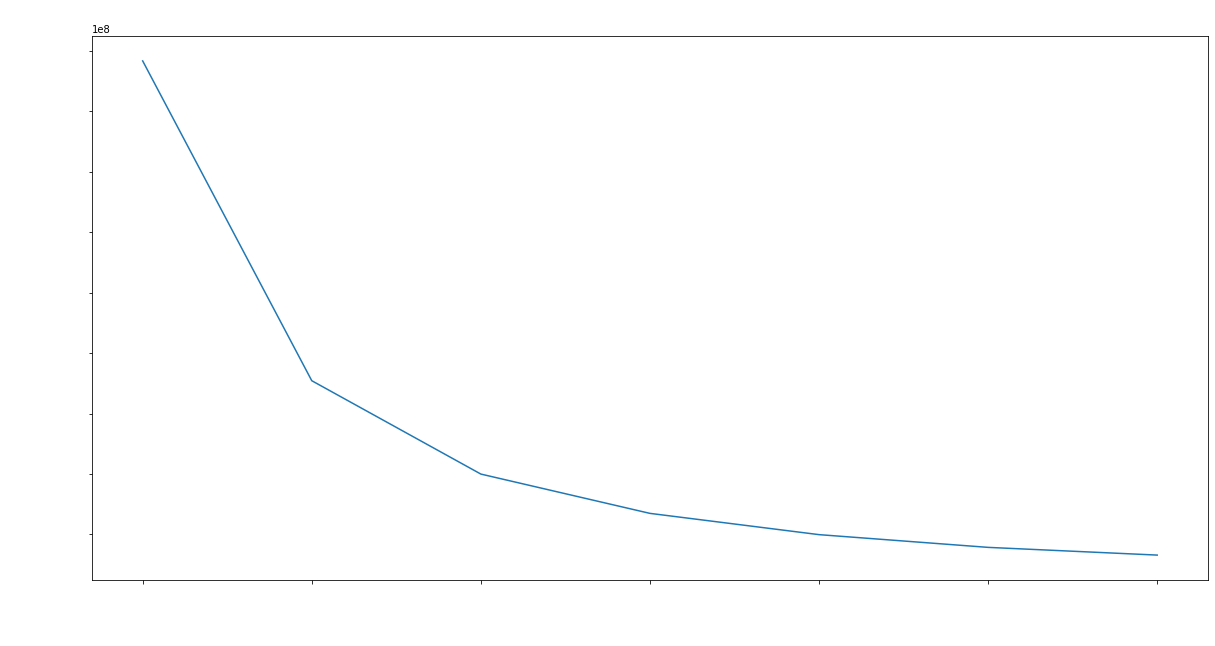

In [80]:
'''
Visualize Elbow graph and decide about possible number of clusters.
'''
plt.title('Elbow', color='w', size=30)
plt.xlabel('K', color='w', size=30)
plt.ylabel('Sum of squared error', color='w', size=30)
plt.xticks(color='w', size=20)
plt.yticks(color='w', size=20)
plt.plot(k_rng,sse)
plt.show()

In [81]:
'''
I Decided to use three clusters and first i will conduct
the clustering with kmeans method and then pca for 2d visualization.
'''
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_groupedby_user_noID)

In [82]:
pca = PCA(n_components=2)
pca_trans = pca.fit_transform(df_groupedby_user_noID)
pca_trans_df = pd.DataFrame(pca_trans)

In [125]:
pca_trans_df['cluster']=y_predicted
pca_trans_df['user_id']=df_groupedby_user.user_id
pca_trans_df.head()

,0,1,cluster,user_id
0,29.138398,-2.333738,0,100001680044
1,-28.857400,-0.489662,2,100005820236
2,8.739610,13.267642,2,100008019713
3,-14.451393,-1.912135,2,100009701666
4,-23.217765,-2.197860,2,100015523811


In [87]:
merged_df = pca_trans_df.merge(df_groupedby_user, on='user_id')

In [127]:
merged_df.head()

,0,1,cluster,user_id,order_id,amount,amount_per_order,comb
0,29.138398,-2.333738,0,100001680044,8,66.300000,8.287500,"Cluster order counts mean: 8.498, Cluster amou..."
1,-28.857400,-0.489662,2,100005820236,1,8.700000,8.700000,"Cluster order counts mean: 2.324, Cluster amou..."
2,8.739610,13.267642,2,100008019713,2,46.100000,23.050000,"Cluster order counts mean: 2.324, Cluster amou..."
3,-14.451393,-1.912135,2,100009701666,3,23.000000,7.666667,"Cluster order counts mean: 2.324, Cluster amou..."
4,-23.217765,-2.197860,2,100015523811,2,14.300000,7.150000,"Cluster order counts mean: 2.324, Cluster amou..."


In [119]:
def comb(var):
    '''
    Conduct a simple topic modeling for my clusters.
    Compute the mean of the order counts, amount and amount_per_order per cluster of each customer. 
    '''
    temp_df  = merged_df[merged_df.cluster == var]
    order_counts_clst = round(temp_df['order_id'].mean(),3)
    amount_clst = round(temp_df['amount'].mean(),3)
    amount_per_order_clst = round(temp_df['amount_per_order'].mean(),3)
    comb = 'Cluster order counts mean: '+str(order_counts_clst)+ ', ' + 'Cluster amount mean: '+str(amount_clst)+ ', ' + 'Cluster amount_per_order mean: '+str(amount_per_order_clst)
    return comb

In [120]:
merged_df['comb'] = merged_df['cluster'].progress_apply(lambda x: comb(x))

100%|██████████| 121943/121943 [17:31<00:00, 116.00it/s]


In [156]:
print("Average type customers: ", merged_df[merged_df.cluster ==0].shape[0]/merged_df.shape[0])
print("VIP customers: ", merged_df[merged_df.cluster ==1].shape[0]/merged_df.shape[0])
print("Low spend customers: ",merged_df[merged_df.cluster ==2].shape[0]/merged_df.shape[0])
print(merged_df.comb[121938])
print(merged_df.comb[121940])
print(merged_df.comb[121942])

Average type customers:  0.21857753212566527
VIP customers:  0.03864100440369681
Low spend customers:  0.7427814634706379
Cluster order counts mean: 8.498, Cluster amount mean: 73.743, Cluster amount_per_order mean: 11.156
Cluster order counts mean: 20.631, Cluster amount mean: 185.017, Cluster amount_per_order mean: 11.062
Cluster order counts mean: 2.324, Cluster amount mean: 18.944, Cluster amount_per_order mean: 9.542


In [153]:
def cluster_naming(x):
    if x== 0:
        return "Average type customers"
    elif x == 1:
        return "VIP customers"
    else:
        return "Low spend customers"

In [154]:
merged_df['cluster_name'] = merged_df['cluster'].progress_apply(lambda x: cluster_naming(x))

100%|██████████| 121943/121943 [00:00<00:00, 799145.67it/s]


In [157]:
merged_df.tail()

,0,1,cluster,user_id,order_id,amount,amount_per_order,comb,cluster_name
121938,43.613898,1.310974,0,99977097654,7,80.900000,11.557143,"Cluster order counts mean: 8.498, Cluster amou...",Average type customers
121939,43.146382,-7.284660,0,99984731133,15,79.700000,5.313333,"Cluster order counts mean: 8.498, Cluster amou...",Average type customers
121940,128.656179,4.621494,1,99988741944,11,165.950000,15.086364,"Cluster order counts mean: 20.631, Cluster amo...",VIP customers
121941,20.267963,-3.520921,0,99990553278,8,57.400000,7.175000,"Cluster order counts mean: 8.498, Cluster amou...",Average type customers
121942,-23.117270,-2.149226,2,99999868710,2,14.400000,7.200000,"Cluster order counts mean: 2.324, Cluster amou...",Low spend customers


In [173]:
clustering_names_perc  = (merged_df.groupby("cluster_name").count()[["user_id"]]/merged_df.shape[0]).reset_index()\


In [179]:
clustering_names_perc = clustering_names_perc.rename(columns={"user_id":"cluster_percentages"})

In [180]:
clustering_names_perc

,cluster_name,cluster_percentages
0,Average type customers,0.218578
1,Low spend customers,0.742781
2,VIP customers,0.038641


In [158]:
merged_df.to_csv("customer_clustering_analysis.csv", index=False) # Save dataframe to use it to streamlit

## Breakfast Customers

In [130]:
df_breakfast = df[df.cuisine == "Breakfast"]
df_groupedby_breakfast_user = df_breakfast.groupby('user_id').agg({'order_id': "count",
                             'amount': 'sum'}).reset_index(drop=False)
                             
df_groupedby_breakfast_user['amount_per_order'] = df_groupedby_breakfast_user.amount/df_groupedby_breakfast_user.order_id

df_groupedby_breakfast_user.sort_values(['order_id', 'amount'], 
                                ascending= [False, False], 
                                #inplace=True
                                ).head()

,user_id,order_id,amount,amount_per_order
6420,154559060124,114,686.000000,6.017544
612,104460666828,99,564.500000,5.702020
2340,119884693362,85,543.100000,6.389412
27076,32214575190,79,156.300000,1.978481
18279,247344644274,70,232.000000,3.314286


In [50]:
def has_ordered_once_breakfast(x):
    if x==1:
        return "Yes"
    else:
        return "No"

In [51]:
df_groupedby_breakfast_user['has_ordered_once_breakfast'] = df_groupedby_breakfast_user['order_id'].apply(lambda x: has_ordered_once_breakfast(x))

In [53]:
df_has_ordered_once_breakfast  = pd.DataFrame(df_groupedby_breakfast_user.has_ordered_once_breakfast.value_counts()/df_groupedby_breakfast_user.shape[0]).reset_index().rename(columns={"index":'has_ordered_once_breakfast','has_ordered_once_breakfast': 'percentages'})
df_has_ordered_once_breakfast

,has_ordered_once_breakfast,percentages
0,No,0.581026
1,Yes,0.418974
